In [134]:
import math
import random
import pandas as pd
import matplotlib.pyplot as plt 

random.seed(148253)

In [135]:
df1 = pd.read_csv('Data/TSPA.csv', header = None, sep = ';')
df2 = pd.read_csv('Data/TSPB.csv', header = None, sep = ';')
df3 = pd.read_csv('Data/TSPC.csv', header = None, sep = ';')
df4 = pd.read_csv('Data/TSPD.csv', header = None, sep = ';')

In [136]:
df1

,0,1,2
0,1510,353,84
1,3042,123,483
2,2145,389,1462
3,1030,365,1986
4,2125,360,145
...,...,...,...
195,1023,1258,197
196,3192,1271,1183
197,3735,1879,1461
198,3983,299,1309


### Distance matrix
Node costs included

In [137]:
def calculate_distance(city1, city2):
    return round(math.sqrt((city1[0]-city2[0])**2 + (city1[1]-city2[1])**2))

In [138]:
def create_distance_matrix(df):
    distance_matrix = [[df.iloc[j, 2] for j in range(df.shape[0])] for i in range(df.shape[0])]
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            if i == j:
                break
            dist = calculate_distance(df.values[i][:2], df.values[j][:2])
            distance_matrix[i][j] += dist
            distance_matrix[j][i] += dist
    return distance_matrix

### Get cost

In [139]:
def get_cost(a, b, df, distance_matrix):
    return distance_matrix[a][b] + df.iloc[b, 2]

### Helpful debugging function for checking the length of the cycle

In [140]:
def check_cycle_length(df, path):
    distance_matrix = create_distance_matrix(df)
    dist = 0
    for index, node in enumerate(path[:-1]):
        dist += distance_matrix[node][path[(index+1) % len(path)]]
    dist += distance_matrix[path[-1]][path[0]]
    return dist

### Random Solution

In [141]:
def random_TSP(df, distance_matrix):
    path = random.sample(range(0, len(distance_matrix)), math.ceil(len(distance_matrix) / 2))
    dist = 0
    for index, item in enumerate(path):
        dist += get_cost(item, path[(index+1) % len(path)], df, distance_matrix)
    return dist, path

### Nearest Neighbour

In [142]:
def nearest_TSP(df, distance_matrix, starting_city):
    dist = 0
    path = [starting_city]

    cycle_length = math.ceil(len(distance_matrix) / 2)

    for i in range(0, cycle_length - 1):
        shortest_distance = math.inf
        shortest_city = -1

        for j in range(len(distance_matrix)):
            if j in path:
                continue
            if get_cost(path[-1], j, df, distance_matrix) < shortest_distance:
                shortest_distance = get_cost(path[-1], j, df, distance_matrix)
                shortest_city = j
        
        path.append(shortest_city)
        dist += shortest_distance

    dist += get_cost(path[-1], starting_city, df, distance_matrix)

    return dist, path

### Greedy Cycle

In [143]:
def greedy_TSP(df, distance_matrix, starting_city):
    dist = 0
    path = [starting_city]

    cycle_length = math.ceil(len(distance_matrix) / 2)

    shortest_distance = math.inf
    shortest_city = -1

    for j in range(len(distance_matrix)):
        if j in path:
            continue

        if get_cost(path[-1], j, df, distance_matrix) < shortest_distance:
            shortest_distance = get_cost(path[-1], j, df, distance_matrix)
            shortest_city = j
    
    path.append(shortest_city)
    dist += shortest_distance
    dist += get_cost(path[-1], starting_city, df, distance_matrix)

    for i in range(0, cycle_length - 2):
        shortest_extra_distance = math.inf
        shortest_city = -1
        shortest_city_index = -1

        for j in range(len(distance_matrix)):
            if j in path:
                continue
            
            for k in range(len(path)):  
                extra_distance = (get_cost(path[k], j, df, distance_matrix) 
                                  + get_cost(j, path[(k+1) % len(path)], df, distance_matrix)
                                  - get_cost(path[k], path[(k+1) % len(path)], df, distance_matrix))
                
                if extra_distance < shortest_extra_distance:
                    shortest_extra_distance = extra_distance
                    shortest_city = j
                    shortest_city_index = k+1
            
        
        path.insert(shortest_city_index, shortest_city)
        dist += shortest_extra_distance
    


    return dist, path

### 2-Regret Cycle

In [144]:
def regret_TSP(df, distance_matrix, starting_city):
    dist = 0
    path = [starting_city]

    cycle_length = math.ceil(len(distance_matrix) / 2)

    shortest_distance = math.inf
    shortest_city = -1

    for j in range(len(distance_matrix)):
        if j in path:
            continue

        if get_cost(path[-1], j, df, distance_matrix) < shortest_distance:
            shortest_distance = get_cost(path[-1], j, df, distance_matrix)
            shortest_city = j
    
    path.append(shortest_city)
    dist += shortest_distance
    dist += get_cost(path[-1], starting_city, df, distance_matrix)

    for i in range(0, cycle_length - 2):
        
        biggest_regret = -1
        biggest_regret_city = -1
        biggest_regret_city_index = -1
        chosen_extra_distance = math.inf

        for j in range(len(distance_matrix)):
            if j in path:
                continue

            first_shortest_distance = math.inf
            first_shortest_city_index = -1

            second_shortest_distance = math.inf
            second_shortest_city_index = -1
            
            for k in range(len(path)):
                extra_distance = (get_cost(path[k], j, df, distance_matrix) 
                                  + get_cost(j, path[(k+1) % len(path)], df, distance_matrix)
                                  - get_cost(path[k], path[(k+1) % len(path)], df, distance_matrix))
                
                if extra_distance < first_shortest_distance:
                    first_shortest_distance = extra_distance
                    first_shortest_city_index = k+1

            for k in range(len(path)):
                if k == first_shortest_city_index:
                    continue

                extra_distance = (get_cost(path[k], j, df, distance_matrix) 
                                  + get_cost(j, path[(k+1) % len(path)], df, distance_matrix)
                                  - get_cost(path[k], path[(k+1) % len(path)], df, distance_matrix))
                
                if extra_distance < second_shortest_distance:
                    first_shortest_distance = extra_distance
                    second_shortest_city_index = k+1
                
            regret = second_shortest_distance - first_shortest_distance
            
            if biggest_regret < regret:
                biggest_regret = regret
                chosen_extra_distance = first_shortest_distance
                biggest_regret_city = j
                biggest_regret_city_index = first_shortest_city_index           
        
        path.insert(biggest_regret_city_index, biggest_regret_city)
        dist += chosen_extra_distance

    return dist, path

### Compare methods

In [145]:
iterations = 1 ### change hardcode to matrix size
nearest_bests = []
greedy_bests = []
regret_bests = []
nearest_best_paths = []
greedy_best_paths = []
regret_best_paths = []
random_best_paths = []

record = True
f = open("results.txt", "w")

for id, df in enumerate([df1, df2, df3, df4]):
    distance_matrix = create_distance_matrix(df)

    print(f'\n==============[Dataset {id+1}]==============')
    print(f'RANDOM TSP')

    min_dist = math.inf
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = random_TSP(df, distance_matrix)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        elif dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    random_best_paths.append(best_path)

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')

    if record:
        f.write(f"Dataset {id+1}\nRandom\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")

    print(f'\nNEAREST NEIGHBOUR TSP')

    min_dist = math.inf
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = nearest_TSP(df, distance_matrix, i)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        elif dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    #assert check_cycle_length(df, best_path) == min_dist

    nearest_bests.append(min_dist)
    nearest_best_paths.append(best_path)

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')

    if record:
        f.write(f"Nearest Neighbour\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")

    print(f'\nGREEDY CYCLE TSP')

    min_dist = math.inf
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = greedy_TSP(df, distance_matrix, i)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        elif dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    #assert check_cycle_length(df, best_path) == min_dist

    greedy_bests.append(min_dist)
    greedy_best_paths.append(best_path)

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')

    if record:
        f.write(f"Greedy Cycle\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")

    print(f'\n2-Regret CYCLE TSP')

    min_dist = math.inf
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = regret_TSP(df, distance_matrix, i)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        elif dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    #assert check_cycle_length(df, best_path) == min_dist

    regret_bests.append(min_dist)
    regret_best_paths.append(best_path)

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')

    if record:
        f.write(f"Regret Cycle\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")

f.close()


==============[Dataset 1]==============
RANDOM TSP
Best solution: [188, 50, 24, 151, 74, 23, 144, 67, 84, 68, 52, 18, 186, 85, 78, 139, 124, 17, 63, 76, 156, 122, 135, 104, 102, 9, 88, 11, 183, 47, 58, 89, 125, 87, 38, 42, 79, 25, 4, 164, 108, 141, 22, 166, 19, 40, 20, 97, 14, 105, 173, 150, 118, 178, 175, 161, 6, 179, 190, 61, 140, 43, 133, 162, 106, 46, 129, 136, 82, 107, 123, 155, 34, 77, 37, 198, 172, 111, 126, 148, 39, 33, 147, 132, 80, 165, 69, 154, 167, 174, 15, 152, 112, 49, 153, 54, 12, 185, 65, 168]
Shortest distance: 367887
Longest distance: 0
Average distance: 367887.0

NEAREST NEIGHBOUR TSP
Best solution: [0, 178, 19, 114, 4, 75, 177, 189, 48, 11, 152, 119, 135, 95, 169, 8, 80, 98, 6, 141, 79, 55, 195, 74, 163, 113, 185, 96, 59, 143, 147, 27, 164, 128, 132, 22, 117, 186, 167, 199, 1, 41, 43, 149, 50, 77, 91, 76, 21, 154, 81, 62, 53, 108, 171, 87, 66, 72, 94, 31, 14, 111, 112, 51, 26, 106, 160, 130, 109, 134, 101, 175, 153, 88, 127, 45, 24, 144, 194, 161, 121, 192, 174, 13

In [146]:
for i in range(4):
    print(f"df{i+1} Nearest {nearest_bests[i]}")

df1 Nearest 145996
df2 Nearest 131620
df3 Nearest 87378
df4 Nearest 79420


In [147]:
for i in range(4):
    print(f"df{i+1} Greedy {greedy_bests[i]}")

df1 Greedy 126359
df2 Greedy 114234
df3 Greedy 76641
df4 Greedy 68904


In [148]:
print(len(nearest_best_paths))
print(len(greedy_best_paths))

4
4


### Visualizations

In [149]:
def plot_cycle(df, cycle, title="Example"):
    plt.figure(figsize=(12, 9))

    # plotting the cycle  
    x = [df.values[i][0] for i in cycle]
    y = [df.values[i][1] for i in cycle]
    x.append(x[0])
    y.append(y[0])
    
    plt.plot(x, y, color='red', linestyle='dashed', linewidth = 2, 
            markerfacecolor='blue', markersize=6) 


    # plotting the points  
    x = [df.values[i][0] for i in range(df.shape[0])]
    y = [df.values[i][1] for i in range(df.shape[0])]
    size = [df.values[i][2] // 40 + 10 for i in range(df.shape[0])]

    plt.scatter(x, y, s=size)

    plt.xlim(0, 4000) 
    plt.ylim(0, 2000) 
    
    plt.title(title) 
    plt.xlabel('x coordinate') 
    plt.ylabel('y coordinate') 
    
    plt.show() 


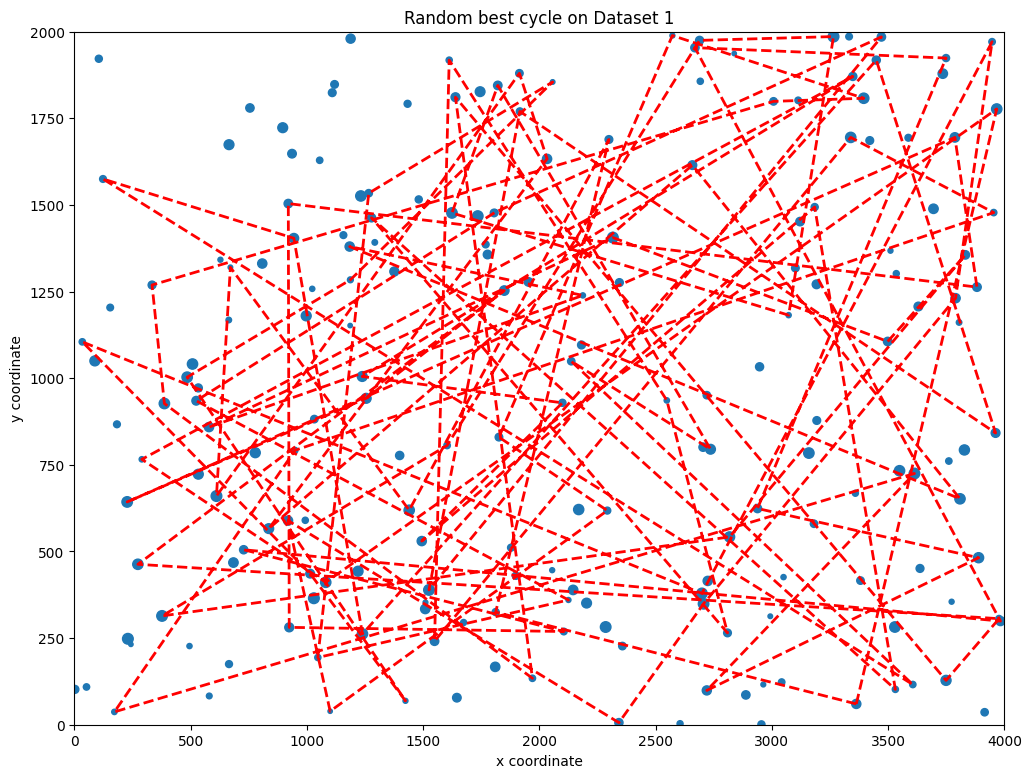

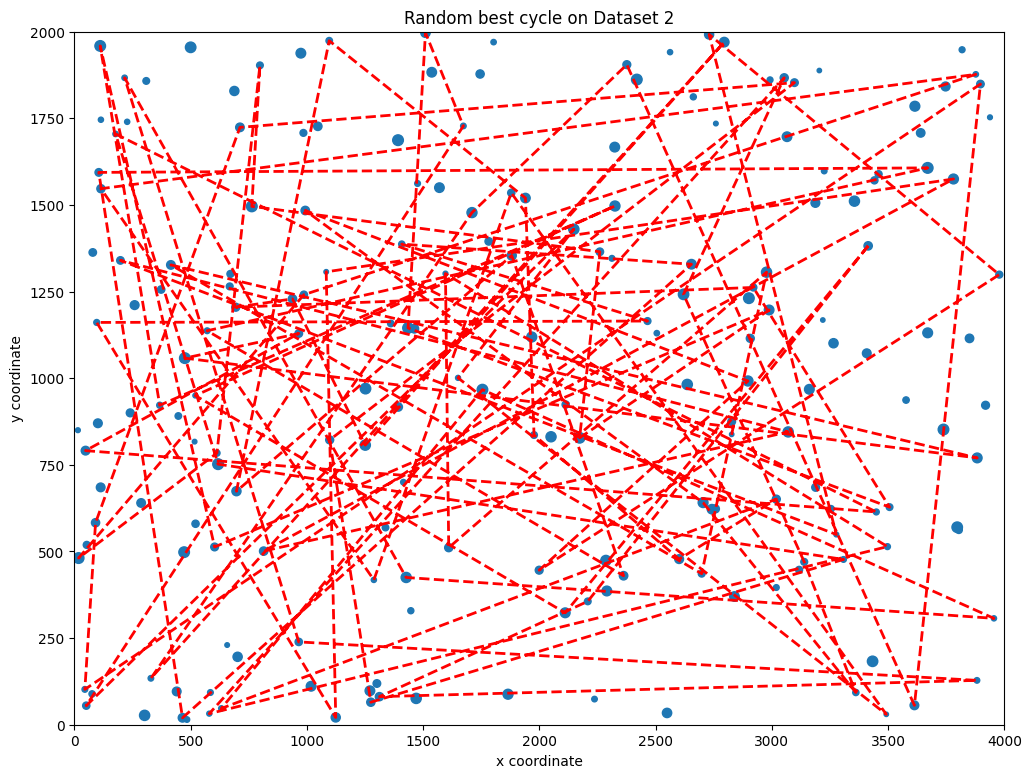

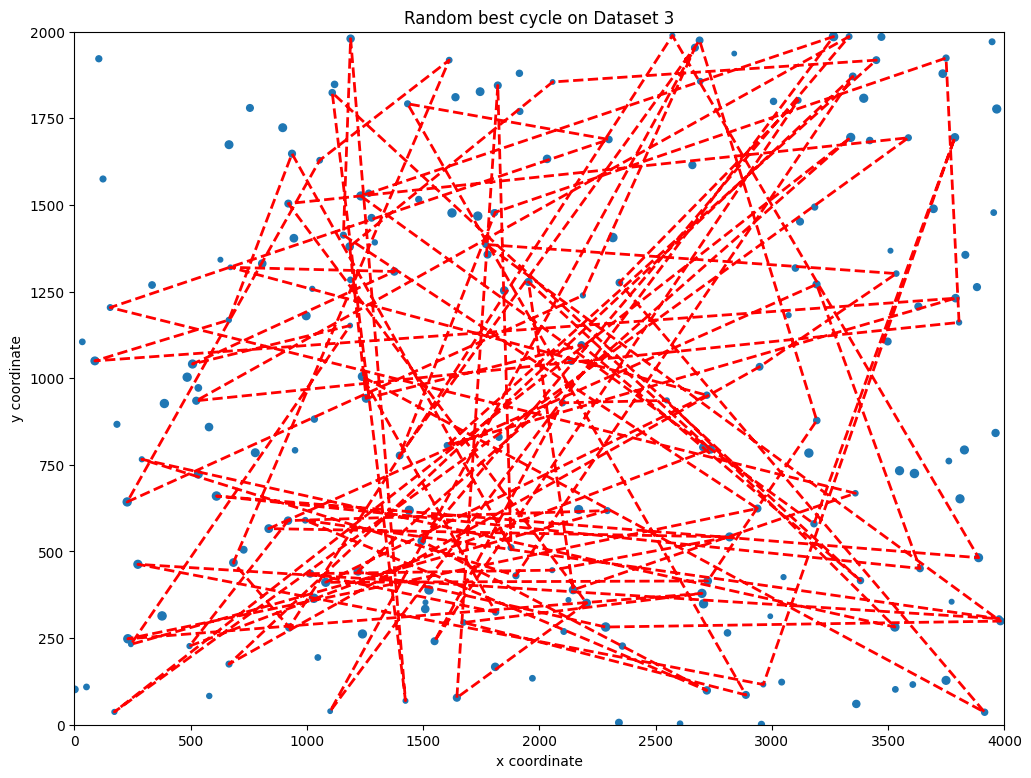

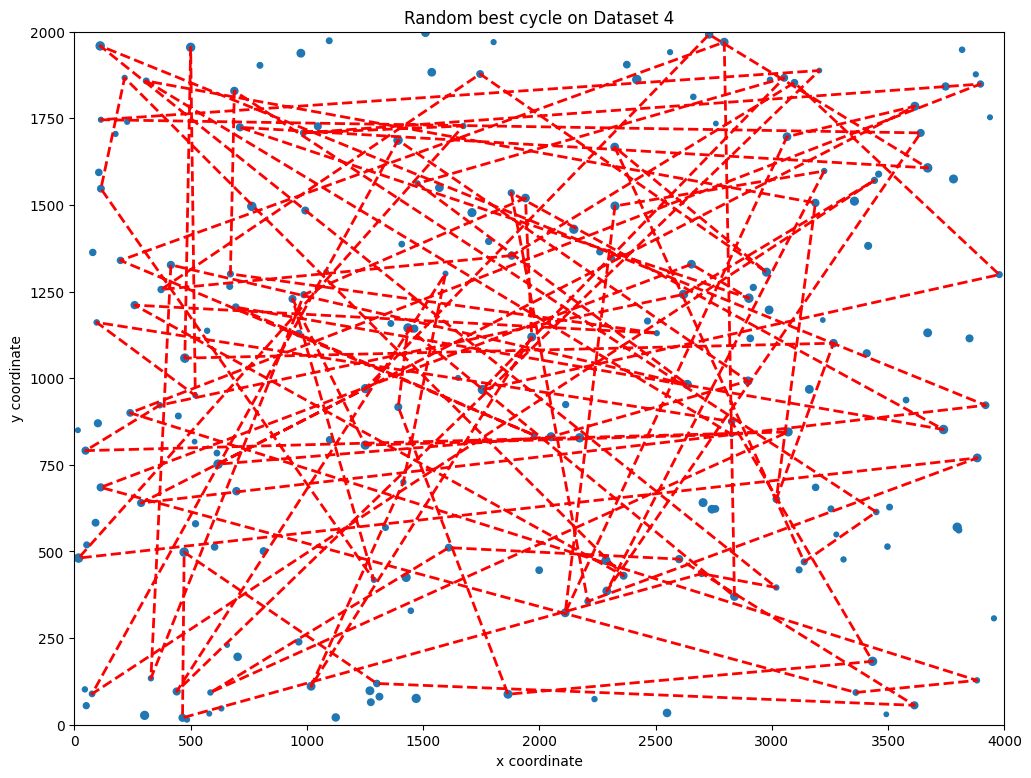

In [150]:
for id, df in enumerate([df1, df2, df3, df4]):
    plot_cycle(df, random_best_paths[id], f"Random best cycle on Dataset {id+1}")

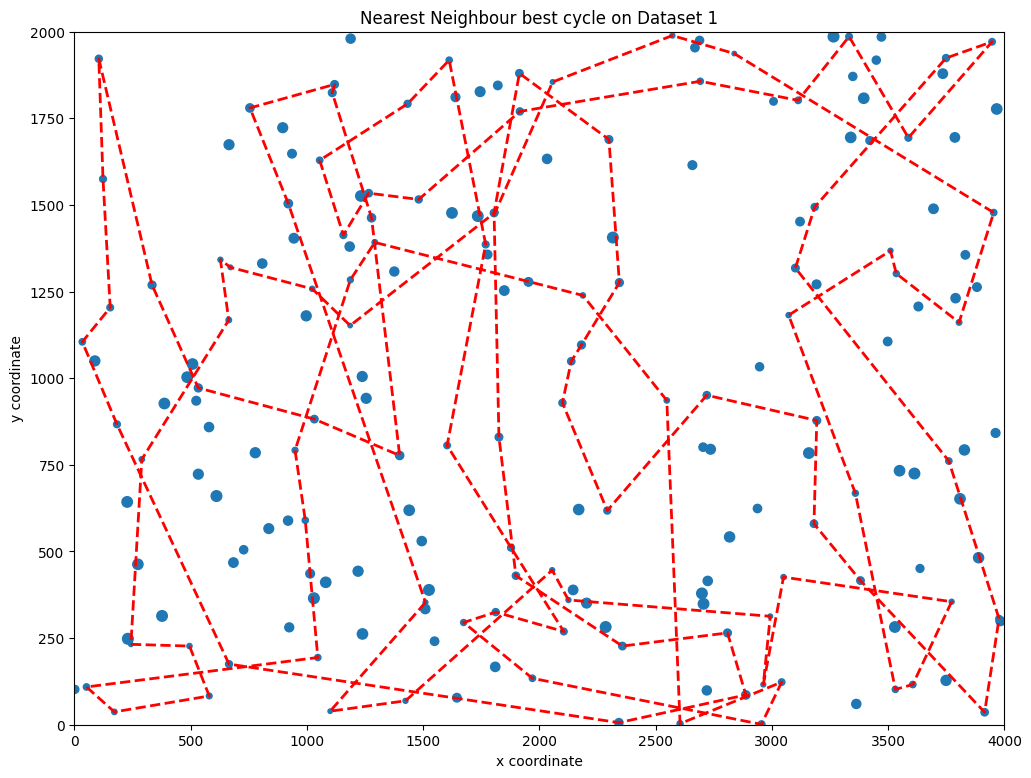

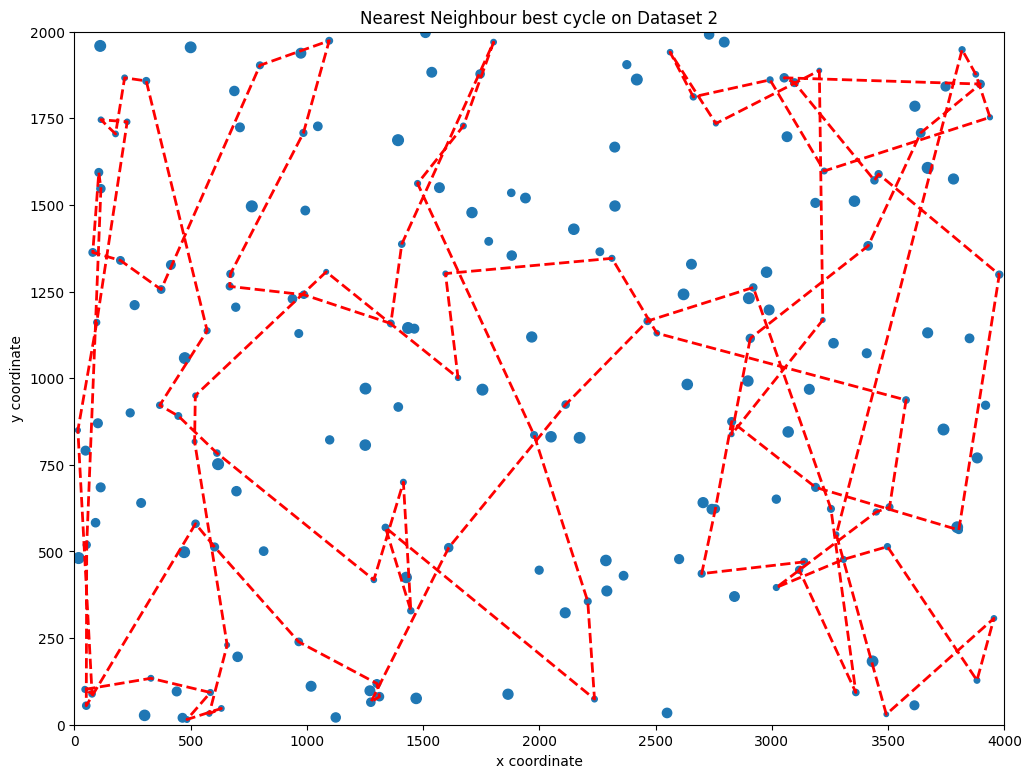

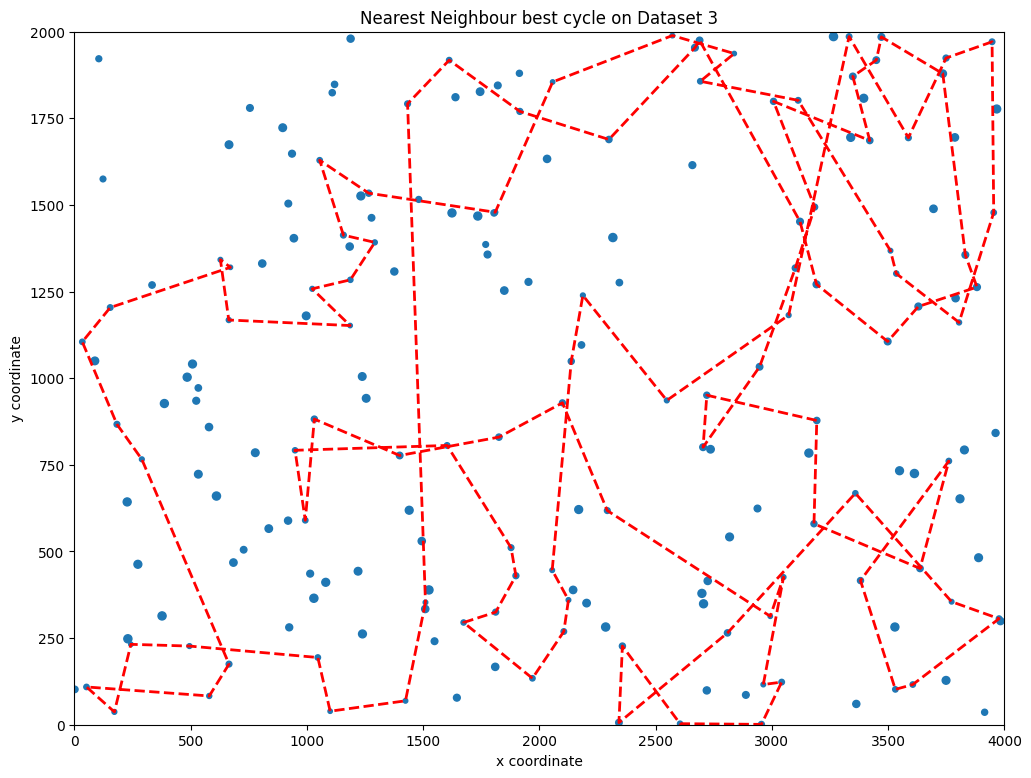

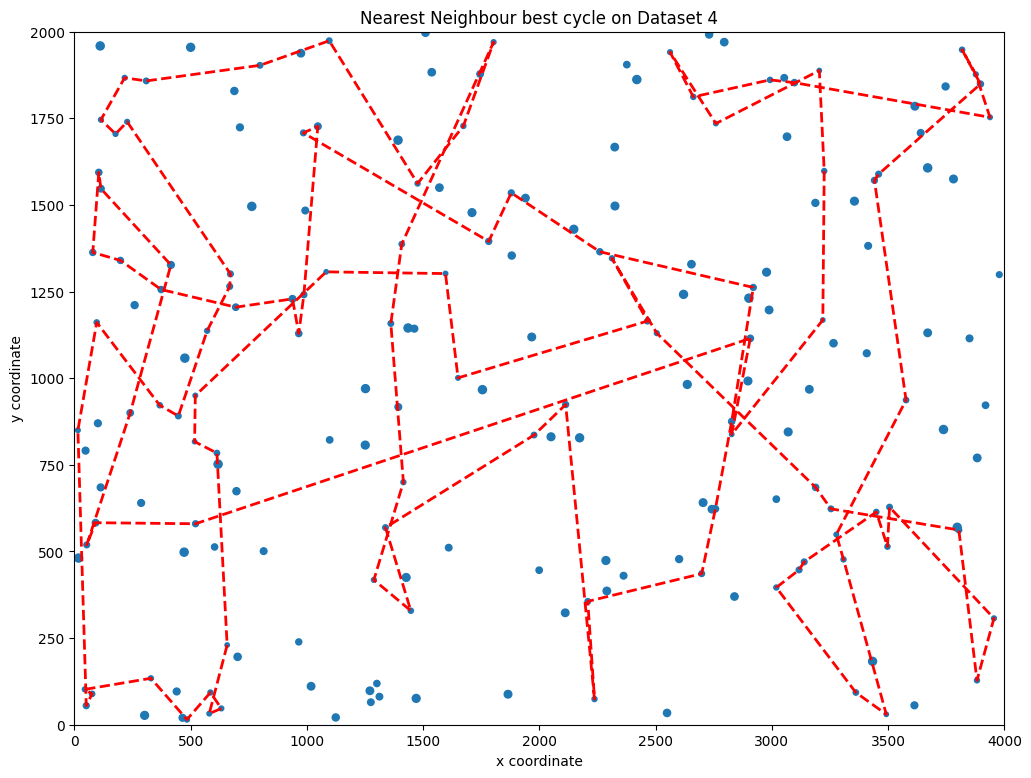

In [151]:
for id, df in enumerate([df1, df2, df3, df4]):
    plot_cycle(df, nearest_best_paths[id], f"Nearest Neighbour best cycle on Dataset {id+1}")

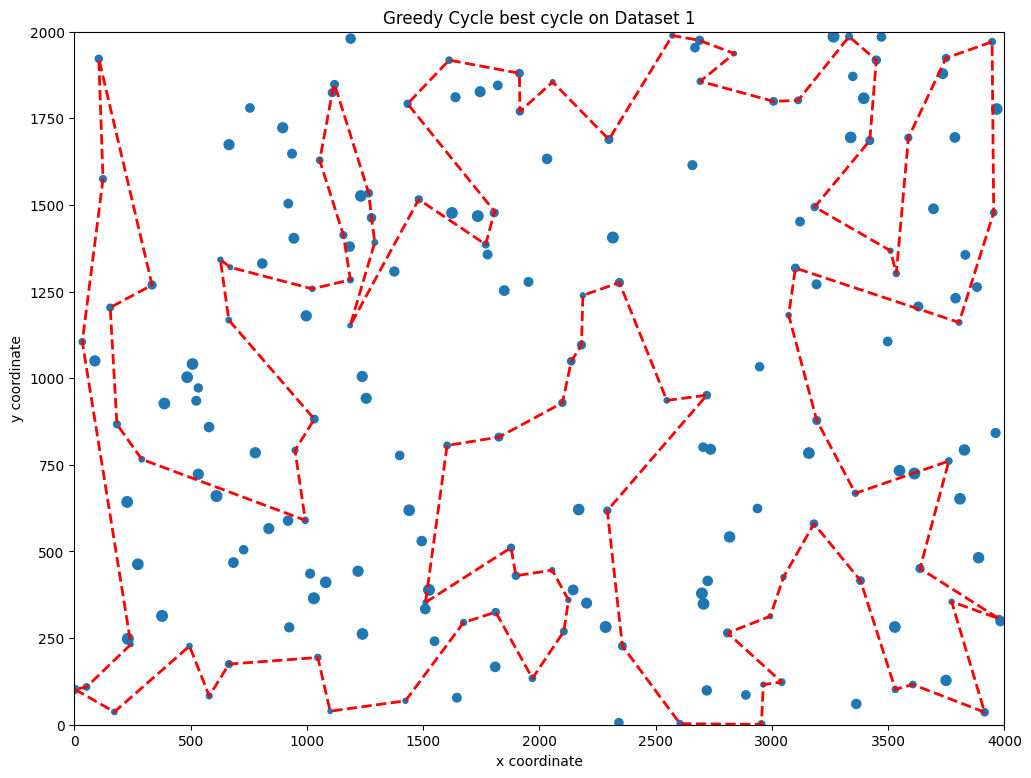

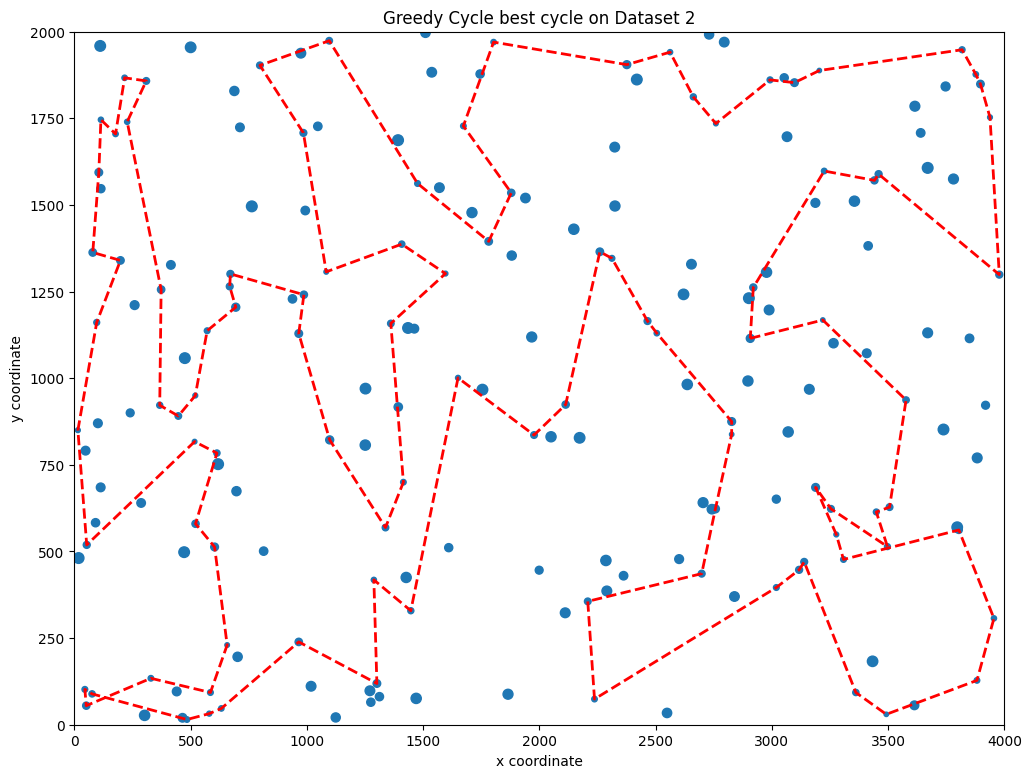

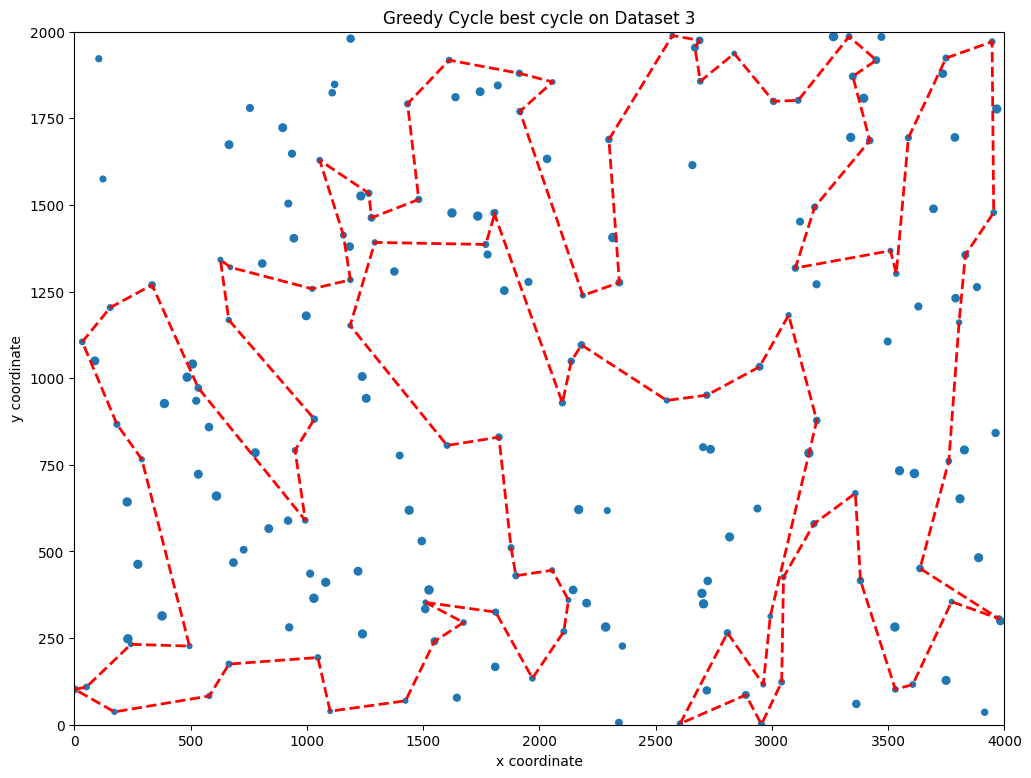

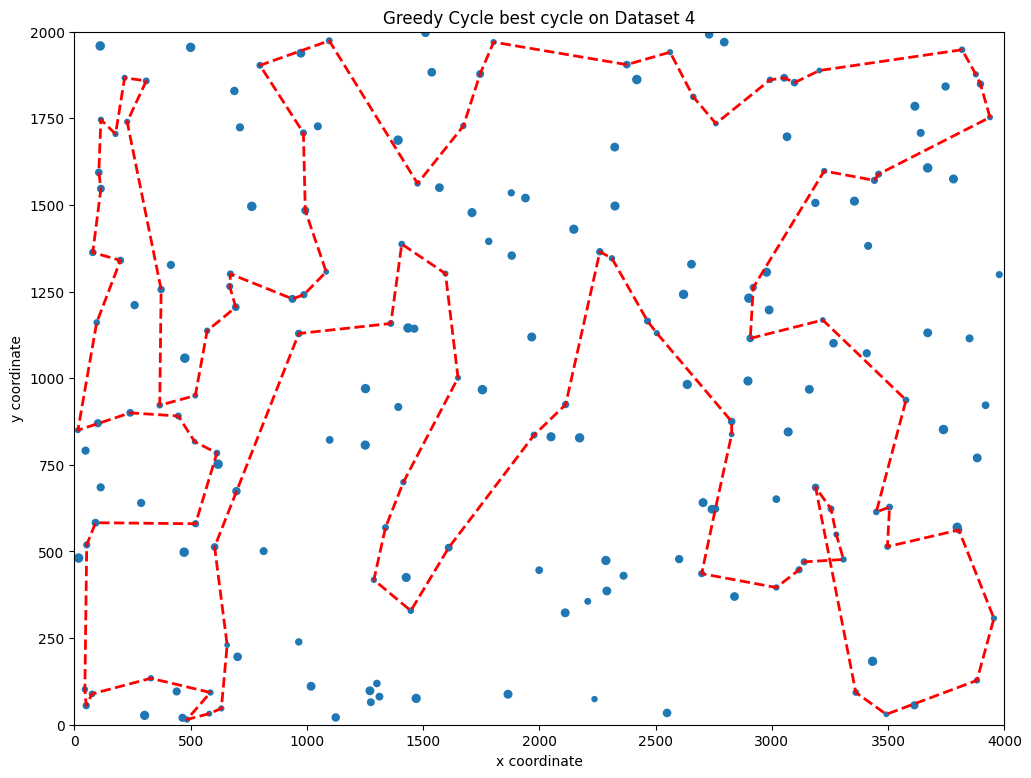

In [152]:
for id, df in enumerate([df1, df2, df3, df4]):
    plot_cycle(df, greedy_best_paths[id], f"Greedy Cycle best cycle on Dataset {id+1}")